# Agente Gerenciador de Estoque
> Agentes Inteligentes, Teorema de Bayes

**Dataset utilizado: [Groceries Dataset - retirado do Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba/data)**

### Setup Inicial

In [400]:
!pip install -qq pgmpy

data_path = "https://raw.githubusercontent.com/sofiaarosa/agente-estoque/refs/heads/main/Groceries%20data.csv" # link para csv

### Utilizando o dataset

In [401]:
import pandas as pd

In [402]:
full_data = pd.read_csv(data_path)
full_data.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [403]:
# organizando a tabela para análise de dados:
# retirando colunas que não serão utilizadas, melhorando a exibição dos dados e adicionando novo campo 'season'

# colunas utilizadas: day_of_week, season, itemDescription->product

full_data = full_data.drop(columns=['Member_number', 'year', 'day'], axis=1)
full_data = full_data.rename(columns={'itemDescription': 'product', 'Date': 'date'})

full_data['day_of_week'] = full_data['day_of_week'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'


full_data['season'] = full_data['month'].apply(get_season)
full_data = full_data.drop(columns=['month'], axis=1)

full_data

,date,product,day_of_week,season
0,2015-07-21,tropical fruit,Tuesday,Winter
1,2015-05-01,whole milk,Friday,Autumn
2,2015-09-19,pip fruit,Saturday,Spring
3,2015-12-12,other vegetables,Saturday,Summer
4,2015-01-02,whole milk,Friday,Summer
...,...,...,...,...
38760,2014-08-10,sliced cheese,Sunday,Winter
38761,2014-02-23,candy,Sunday,Summer
38762,2014-04-16,cake bar,Wednesday,Autumn
38763,2014-03-12,fruit/vegetable juice,Wednesday,Autumn


**Analisaremos a demanda dos produtos por dia, para depois conseguir prever a mesma dados os fatores**

In [404]:
product_count_date = full_data.groupby(['date', 'product']).size().reset_index(name='count')
product_count_date.head()

,date,product,count
0,2014-01-01,Instant food products,2
1,2014-01-01,berries,1
2,2014-01-01,bottled beer,1
3,2014-01-01,bottled water,4
4,2014-01-01,brown bread,1


In [405]:
# calcular a média de vendas dos produtos por dia
mean_sales_product = product_count_date.groupby('product')['count'].mean().reset_index(name='mean_sales')
mean_sales_product.head()

,product,mean_sales
0,Instant food products,1.052632
1,UHT-milk,1.214286
2,abrasive cleaner,1.000000
3,artif. sweetener,1.035714
4,baby cosmetics,1.000000


**Vamos também armazenar a média de vendas por dia de cada produto, pois isso será informação para o nosso agente decidir se precisa estocar esse produto ou não**

In [406]:
product_mean_sales = mean_sales_product.set_index('product')['mean_sales'].to_dict()
product_mean_sales

{'Instant food products': 1.0526315789473684,
 'UHT-milk': 1.2142857142857142,
 'abrasive cleaner': 1.0,
 'artif. sweetener': 1.0357142857142858,
 'baby cosmetics': 1.0,
 'bags': 1.0,
 'baking powder': 1.1090909090909091,
 'bathroom cleaner': 1.0625,
 'beef': 1.5087719298245614,
 'berries': 1.2386363636363635,
 'beverages': 1.1784037558685445,
 'bottled beer': 1.631828978622328,
 'bottled water': 1.8294117647058823,
 'brandy': 1.0,
 'brown bread': 1.438287153652393,
 'butter': 1.4471544715447155,
 'butter milk': 1.1535087719298245,
 'cake bar': 1.0568181818181819,
 'candles': 1.0819672131147542,
 'candy': 1.1347150259067358,
 'canned beer': 1.6482758620689655,
 'canned fish': 1.1485148514851484,
 'canned fruit': 1.0,
 'canned vegetables': 1.0933333333333333,
 'cat food': 1.1419354838709677,
 'cereals': 1.0,
 'chewing gum': 1.1104294478527608,
 'chicken': 1.383606557377049,
 'chocolate': 1.2184300341296928,
 'chocolate marshmallow': 1.0169491525423728,
 'citrus fruit': 1.746236559139785

In [407]:
# um produto terá demanda alta quando tiver suas vendas 10% maiores do que a média de vendas no histórico
product_data = product_count_date.merge(mean_sales_product, on='product')
product_data['demand'] = product_data.apply(lambda row: 'High' if row['count'] >= row['mean_sales'] else 'Normal', axis=1)

product_data

,date,product,count,mean_sales,demand
0,2014-01-01,Instant food products,2,1.052632,High
1,2014-01-01,berries,1,1.238636,Normal
2,2014-01-01,bottled beer,1,1.631829,Normal
3,2014-01-01,bottled water,4,1.829412,High
4,2014-01-01,brown bread,1,1.438287,Normal
...,...,...,...,...,...
25226,2015-12-30,tropical fruit,1,1.954545,Normal
25227,2015-12-30,turkey,1,1.095890,Normal
25228,2015-12-30,whipped/sour cream,1,1.576190,Normal
25229,2015-12-30,whole milk,3,3.589670,Normal


In [408]:
# completando a tabela adicionando o campo demanda - essa será a tabela que utilizaremos até o fim do trabalho
data_frame = full_data.merge(product_data[['date', 'product', 'demand']], on=['date', 'product'])
data_frame.drop(columns=['date'], inplace=True)
data_frame

,product,day_of_week,season,demand
0,tropical fruit,Tuesday,Winter,High
1,whole milk,Friday,Autumn,High
2,pip fruit,Saturday,Spring,High
3,other vegetables,Saturday,Summer,Normal
4,whole milk,Friday,Summer,High
...,...,...,...,...
38760,sliced cheese,Sunday,Winter,Normal
38761,candy,Sunday,Summer,Normal
38762,cake bar,Wednesday,Autumn,Normal
38763,fruit/vegetable juice,Wednesday,Autumn,Normal


**dados importantes derivados dessa tabela**
* Número de produtos distintos
* Número de vezes que um produto apareceu com demanda "alta" dadas todas as combinações possíveis
* Número de vezes que um produto apareceu com demanda "normal" dadas todas as combinações possíveis

**Vamos verificar se o dataset oferece todas as combinações possíveis de situação**  
Ou seja, se temos dados sobre a venda de todos os produtos possíveis em todos os dias da semana possíveis e em todas as estações do ano possíveis

In [409]:
# número de combinações possíveis entre os fatores para demanda: produtos x dias da semana x estações do ano
num_combination = data_frame['product'].nunique() * 7 * 4
print(f"Número de combinações possíveis: {num_combination}")

Número de combinações possíveis: 4676


In [410]:
data_combinations = data_frame.groupby(['product', 'day_of_week', 'season']).size().reset_index(name='situation_count')
s = data_combinations.count()
s

,0
product,3774
day_of_week,3774
season,3774
situation_count,3774


A tabela não oferece todas as combinações possíveis. Por isso, teremos que criar uma tabela com todas as combinações possíveis, sendo que, as que não aparecem na tabela original terão a coluna `demand`em `Normal`.

In [411]:
# criando uma tabela com todas as situações

import itertools

all_combinations = pd.DataFrame(list(itertools.product(data_frame['product'].unique(), data_frame['day_of_week'].unique(), data_frame['season'].unique())),
                                columns=['product', 'day_of_week', 'season'])
s = all_combinations.count()
s

,0
product,4676
day_of_week,4676
season,4676


In [412]:
merged_data = all_combinations.merge(data_frame, on=['product', 'day_of_week', 'season'], how='left')
# preencher demandas nulas com 'Normal'
merged_data['demand'] = merged_data['demand'].fillna('Normal')
merged_data

,product,day_of_week,season,demand
0,tropical fruit,Tuesday,Winter,High
1,tropical fruit,Tuesday,Winter,Normal
2,tropical fruit,Tuesday,Winter,High
3,tropical fruit,Tuesday,Winter,Normal
4,tropical fruit,Tuesday,Winter,High
...,...,...,...,...
39662,preservation products,Thursday,Summer,Normal
39663,preservation products,Sunday,Winter,Normal
39664,preservation products,Sunday,Autumn,Normal
39665,preservation products,Sunday,Spring,Normal


In [413]:
# contagem de vezes de demandas altas e normais
demand_counts = merged_data.groupby(['product', 'day_of_week', 'season'])['demand'].apply(lambda x: (x == 'High').sum()).reset_index(name='high_demand_count')
total_counts = merged_data.groupby(['product', 'day_of_week', 'season']).size().reset_index(name='total_count')
demand_counts = demand_counts.merge(total_counts, on=['product', 'day_of_week', 'season'])
demand_counts['normal_demand_count'] = demand_counts['total_count'] - demand_counts['high_demand_count']


demand_counts

,product,day_of_week,season,high_demand_count,total_count,normal_demand_count
0,Instant food products,Friday,Autumn,0,4,4
1,Instant food products,Friday,Spring,0,1,1
2,Instant food products,Friday,Summer,0,3,3
3,Instant food products,Friday,Winter,0,2,2
4,Instant food products,Monday,Autumn,0,1,1
...,...,...,...,...,...,...
4671,zwieback,Tuesday,Winter,0,4,4
4672,zwieback,Wednesday,Autumn,0,1,1
4673,zwieback,Wednesday,Spring,0,2,2
4674,zwieback,Wednesday,Summer,0,3,3


In [414]:
products = list(demand_counts['product'].unique())
high_demand_count = list(demand_counts['high_demand_count'])
normal_demand_count = list(demand_counts['normal_demand_count'])
total_demand_count = list(demand_counts['total_count'])

num_products = len(products)
print(f"Número de produtos distintos: {num_products}")
print(f"Produtos {products}")
print(f"Demandas altas para todas as combinações dos fatores: {high_demand_count}")
print(f"Demandas normais para todas as combinações dos fatores: {normal_demand_count}")
print(f"Total de vezes que cada combinação dos fatores apareceu: {total_demand_count}")

Número de produtos distintos: 167
Produtos ['Instant food products', 'UHT-milk', 'abrasive cleaner', 'artif. sweetener', 'baby cosmetics', 'bags', 'baking powder', 'bathroom cleaner', 'beef', 'berries', 'beverages', 'bottled beer', 'bottled water', 'brandy', 'brown bread', 'butter', 'butter milk', 'cake bar', 'candles', 'candy', 'canned beer', 'canned fish', 'canned fruit', 'canned vegetables', 'cat food', 'cereals', 'chewing gum', 'chicken', 'chocolate', 'chocolate marshmallow', 'citrus fruit', 'cleaner', 'cling film/bags', 'cocoa drinks', 'coffee', 'condensed milk', 'cooking chocolate', 'cookware', 'cream', 'cream cheese ', 'curd', 'curd cheese', 'decalcifier', 'dental care', 'dessert', 'detergent', 'dish cleaner', 'dishes', 'dog food', 'domestic eggs', 'female sanitary products', 'finished products', 'fish', 'flour', 'flower (seeds)', 'flower soil/fertilizer', 'frankfurter', 'frozen chicken', 'frozen dessert', 'frozen fish', 'frozen fruits', 'frozen meals', 'frozen potato products',

### Resumo dos dados para realização de testes

Modificaremos os dados e criaremos gráficos para conseguirmos ter base de sucesso para os testes que realizaremos. Utilizaremos a biblioteca `mathplotlib` para isso.

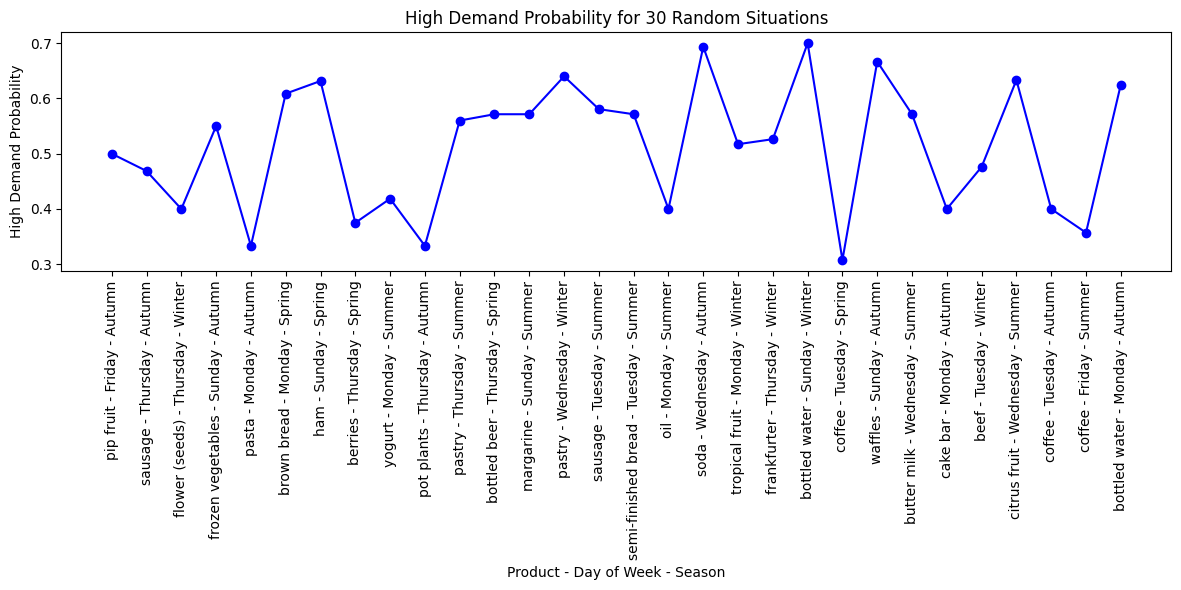

In [439]:
import matplotlib.pyplot as plt

demand_counts['high_demand_probability'] = demand_counts['high_demand_count'] / demand_counts['total_count']
filtered_demand_counts = demand_counts[(demand_counts['high_demand_probability'] >= 0.3) & (demand_counts['high_demand_probability'] <= 0.7)]

random_situations = filtered_demand_counts.sample(n=30, random_state=42)

random_situations['situation'] = random_situations.apply(lambda row: f"{row['product']} - {row['day_of_week']} - {row['season']}", axis=1)

plt.figure(figsize=(12, 6))

plt.plot(random_situations['situation'], random_situations['high_demand_probability'], marker='o', linestyle='-', color='b')

plt.xticks(rotation=90)

plt.xlabel('Product - Day of Week - Season')
plt.ylabel('High Demand Probability')
plt.title('High Demand Probability for 30 Random Situations')

plt.tight_layout()  # Adjust the layout so labels don't overlap
plt.show()



### Utilizaremos o teorema de bayes como base para o nosso agente
Precisaremos calcular as probabilidades de cada fator (qual a probabilidade de ser segunda-feira? qual a probabilidade de ser outono?) e também as probabilidades condicionais da variável `demand` (qual a probabilidade de a demanda ser alta, dado que estamos falando de apples e é segunda feira e outono?)

Utilizaremos isso para construir as CPDs que irão na nossa rede bayeseana

In [416]:
# probabilidade de ser qualquer dia da semana: 1/7
day_of_week_prob = [[1/7] for i in range(7)]
print(day_of_week_prob)
day_of_week_state_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

[[0.14285714285714285], [0.14285714285714285], [0.14285714285714285], [0.14285714285714285], [0.14285714285714285], [0.14285714285714285], [0.14285714285714285]]


In [417]:
# probabilidade de ser qualquer estação do ano: 1/4
season_prob = [[1/4] for i in range(4)]
print(season_prob)
season_state_names = ['Summer', 'Autumn', 'Winter', 'Spring']

[[0.25], [0.25], [0.25], [0.25]]


In [418]:
# probabilidade de ser qualquer produto: 1/número de produtos
product_prob = [[1/num_products] for i in range(num_products)]
print(product_prob)
products_state_names = products

[[0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952095809], [0.005988023952

In [419]:
# probabilidade condicional da demanda dados os 3 fatores anteriores
high_demand_prob = [high_demand_count[i] / total_demand_count[i] for i in range(len(high_demand_count))]
normal_demand_prob = [normal_demand_count[i] / total_demand_count[i] for i in range(len(normal_demand_count))]

print(high_demand_prob)
print(normal_demand_prob)

demand_state_names = ['High', 'Normal']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.3333333333333333, 0.5, 0.25, 0.0, 0.18181818181818182, 0.18181818181818182, 0.36363636363636365, 0.2, 0.26666666666666666, 0.5625, 0.18181818181818182, 0.0, 0.4, 0.42857142857142855, 0.0, 0.45454545454545453, 0.2222222222222222, 0.5333333333333333, 0.625, 0.5, 0.18181818181818182, 0.46153846153846156, 0.18181818181818182, 0.4, 0.3333333333333333, 0.2222222222222222, 0.36363636363636365, 0.6363636363636364, 0.4, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

**Criando os cpds e a rede bayeseana**

In [420]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

In [421]:
# distribuição de probabilidade - day_of_week
cpd_day_of_week = TabularCPD(
    variable='day_of_week',
    variable_card=7,
    values=day_of_week_prob,
    state_names={
        'day_of_week': day_of_week_state_names
    },
)

print(cpd_day_of_week)

+------------------------+----------+
| day_of_week(Monday)    | 0.142857 |
+------------------------+----------+
| day_of_week(Tuesday)   | 0.142857 |
+------------------------+----------+
| day_of_week(Wednesday) | 0.142857 |
+------------------------+----------+
| day_of_week(Thursday)  | 0.142857 |
+------------------------+----------+
| day_of_week(Friday)    | 0.142857 |
+------------------------+----------+
| day_of_week(Saturday)  | 0.142857 |
+------------------------+----------+
| day_of_week(Sunday)    | 0.142857 |
+------------------------+----------+


In [422]:
# distribuição de probabilidade - season
cpd_season = TabularCPD(
    variable='season',
    variable_card=4,
    values=season_prob,
    state_names={
        'season': season_state_names
    },
)

print(cpd_season)

+----------------+------+
| season(Summer) | 0.25 |
+----------------+------+
| season(Autumn) | 0.25 |
+----------------+------+
| season(Winter) | 0.25 |
+----------------+------+
| season(Spring) | 0.25 |
+----------------+------+


In [423]:
# distribuição de probabilidade - produtos
cpd_product = TabularCPD(
    variable='product',
    variable_card=num_products,
    values=product_prob,
    state_names={
        'product': products_state_names
    },
)
print(cpd_product)

+------------------------------------+------------+
| product(Instant food products)     | 0.00598802 |
+------------------------------------+------------+
| product(UHT-milk)                  | 0.00598802 |
+------------------------------------+------------+
| product(abrasive cleaner)          | 0.00598802 |
+------------------------------------+------------+
| product(artif. sweetener)          | 0.00598802 |
+------------------------------------+------------+
| product(baby cosmetics)            | 0.00598802 |
+------------------------------------+------------+
| product(bags)                      | 0.00598802 |
+------------------------------------+------------+
| product(baking powder)             | 0.00598802 |
+------------------------------------+------------+
| product(bathroom cleaner)          | 0.00598802 |
+------------------------------------+------------+
| product(beef)                      | 0.00598802 |
+------------------------------------+------------+
| product(be

In [424]:
# distribuição de probabilidade condicional - demand
cpd_demand = TabularCPD(
    variable='demand',
    variable_card=2,
    values=[high_demand_prob, normal_demand_prob],
    evidence=['product', 'day_of_week', 'season'],
    evidence_card=[num_products, 7, 4],
    state_names={
        'product': products_state_names,
        'day_of_week': day_of_week_state_names,
        'season': season_state_names,
        'demand': demand_state_names,
    },
)
print(cpd_demand)

+----------------+-----+---------------------+---------------------+
| product        | ... | product(zwieback)   | product(zwieback)   |
+----------------+-----+---------------------+---------------------+
| day_of_week    | ... | day_of_week(Sunday) | day_of_week(Sunday) |
+----------------+-----+---------------------+---------------------+
| season         | ... | season(Winter)      | season(Spring)      |
+----------------+-----+---------------------+---------------------+
| demand(High)   | ... | 0.0                 | 0.0                 |
+----------------+-----+---------------------+---------------------+
| demand(Normal) | ... | 1.0                 | 1.0                 |
+----------------+-----+---------------------+---------------------+


In [425]:
# criando o modelo bayesiano
model = BayesianNetwork([
    ('day_of_week', 'demand'),
    ('season', 'demand'),
    ('product', 'demand')
])

model.add_cpds(cpd_day_of_week, cpd_season, cpd_product, cpd_demand)

assert model.check_model()

**Testando a rede bayesiana para prever a demanda utilizando a função `VariableElimination.query()`**

In [426]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)

In [440]:
import random as rand
#product = products_state_names[rand.randint(0, num_products-1)]
#day_of_week = day_of_week_state_names[rand.randint(0, 6)]
#season = season_state_names[rand.randint(0, 3)]

product = 'bottled water'
day_of_week = 'Monday'
season = 'Autumn'

print(f"Product: {product}")
print(f"Day of week: {day_of_week}")
print(f"Season: {season}")

Product: bottled water
Day of week: Monday
Season: Autumn


In [444]:
query = inference.query(variables=['demand'], evidence={'product': product, 'day_of_week': day_of_week,'season': season})
print(query)
print(query.values[0])

+----------------+---------------+
| demand         |   phi(demand) |
+================+===============+
| demand(High)   |        0.7188 |
+----------------+---------------+
| demand(Normal) |        0.2812 |
+----------------+---------------+
0.71875


### Construção do Agente
Todos os dias, o agente deverá prever a demanda de todos os produtos do estoque dados os fatores: dia da semana e estação do ano. Em seguida, ele verifica o estoque. Se a demanda para o produto for alta e o estoque estiver abaixo ou igual à média de compras do item, ele deve fazer estoque para ele.

In [429]:
# relembrando que armazenamos a média de vendas de cada produto na seguinte variável
product_mean_sales

{'Instant food products': 1.0526315789473684,
 'UHT-milk': 1.2142857142857142,
 'abrasive cleaner': 1.0,
 'artif. sweetener': 1.0357142857142858,
 'baby cosmetics': 1.0,
 'bags': 1.0,
 'baking powder': 1.1090909090909091,
 'bathroom cleaner': 1.0625,
 'beef': 1.5087719298245614,
 'berries': 1.2386363636363635,
 'beverages': 1.1784037558685445,
 'bottled beer': 1.631828978622328,
 'bottled water': 1.8294117647058823,
 'brandy': 1.0,
 'brown bread': 1.438287153652393,
 'butter': 1.4471544715447155,
 'butter milk': 1.1535087719298245,
 'cake bar': 1.0568181818181819,
 'candles': 1.0819672131147542,
 'candy': 1.1347150259067358,
 'canned beer': 1.6482758620689655,
 'canned fish': 1.1485148514851484,
 'canned fruit': 1.0,
 'canned vegetables': 1.0933333333333333,
 'cat food': 1.1419354838709677,
 'cereals': 1.0,
 'chewing gum': 1.1104294478527608,
 'chicken': 1.383606557377049,
 'chocolate': 1.2184300341296928,
 'chocolate marshmallow': 1.0169491525423728,
 'citrus fruit': 1.746236559139785

In [430]:
# agora vamos gerar uma variável de estoque

import random

storage = {}
for product in products:
    storage[product] = random.randint(0, 6)

storage

{'Instant food products': 0,
 'UHT-milk': 6,
 'abrasive cleaner': 5,
 'artif. sweetener': 3,
 'baby cosmetics': 2,
 'bags': 3,
 'baking powder': 6,
 'bathroom cleaner': 1,
 'beef': 5,
 'berries': 0,
 'beverages': 1,
 'bottled beer': 2,
 'bottled water': 3,
 'brandy': 1,
 'brown bread': 1,
 'butter': 0,
 'butter milk': 0,
 'cake bar': 6,
 'candles': 4,
 'candy': 4,
 'canned beer': 2,
 'canned fish': 3,
 'canned fruit': 3,
 'canned vegetables': 3,
 'cat food': 3,
 'cereals': 4,
 'chewing gum': 2,
 'chicken': 6,
 'chocolate': 5,
 'chocolate marshmallow': 4,
 'citrus fruit': 5,
 'cleaner': 2,
 'cling film/bags': 1,
 'cocoa drinks': 1,
 'coffee': 0,
 'condensed milk': 2,
 'cooking chocolate': 2,
 'cookware': 3,
 'cream': 5,
 'cream cheese ': 0,
 'curd': 6,
 'curd cheese': 6,
 'decalcifier': 5,
 'dental care': 2,
 'dessert': 3,
 'detergent': 5,
 'dish cleaner': 4,
 'dishes': 1,
 'dog food': 1,
 'domestic eggs': 2,
 'female sanitary products': 3,
 'finished products': 5,
 'fish': 4,
 'flour':

In [445]:
# definição do agente

from datetime import datetime

class StorageAgent:
    def __init__(self, product_mean_sales, storage, bayesian_network):
        self.product_mean_sales = product_mean_sales
        self.storage = storage
        self.inference = VariableElimination(bayesian_network)

    def get_demand(self, product:str, day_of_week:str = None, season:str = None):
        ev = {}
        if product:
            ev['product'] = product
        if day_of_week:
            ev['day_of_week'] = day_of_week
        if season:
            ev['season'] = season
        query = self.inference.query(variables=['demand'], evidence=ev)
        query = query.values
        if(query[0] > query[1]):
            return {'demand': 'High', 'query': query}
        else:
            return {'demand': 'Normal', 'query': query}

    def get_storage(self, product:str):
        return self.storage[product]

    def get_mean_sales(self, product:str):
        return self.product_mean_sales[product]

    def get_storage_state(self, product:str):
        storage = self.get_storage(product)
        mean_sales = self.get_mean_sales(product)
        if storage <= mean_sales:
            return mean_sales - storage
        elif storage > mean_sales:
            return 0

    def get_day_of_week(self, date:datetime = None):
        if not date:
            date = datetime.now()
        return date.strftime('%A')

    def get_season(self, date:datetime = None):
        if not date:
            date = datetime.now()

        month = date.month
        if month in [12, 1, 2]:
            return 'Summer'
        elif month in [3, 4, 5]:
            return 'Autumn'
        elif month in [6, 7, 8]:
            return 'Winter'
        elif month in [9, 10, 11]:
            return 'Spring'

    def run(self, date:datetime = None):
        for product in products:
            demand = self.get_demand(product, self.get_day_of_week(date), self.get_season(date))
            storage_state = self.get_storage_state(product)
            if demand['demand'] == 'High':
                print(f"Product: {product} with High Demand")
                if storage_state > 0:
                  print(f"Buying product: {product}")
                  self.storage[product] += storage_state


### Executando o agente

In [446]:
agent = StorageAgent(product_mean_sales, storage, model)
agent.run()

Product: beef with High Demand
Product: berries with High Demand
Buying product: berries
Product: bottled beer with High Demand
Product: bottled water with High Demand
Product: brandy with High Demand
Product: canned beer with High Demand
Product: canned fruit with High Demand
Product: cereals with High Demand
Product: chicken with High Demand
Product: citrus fruit with High Demand
Product: cocoa drinks with High Demand
Product: coffee with High Demand
Buying product: coffee
Product: decalcifier with High Demand
Product: domestic eggs with High Demand
Product: female sanitary products with High Demand
Product: flower soil/fertilizer with High Demand
Buying product: flower soil/fertilizer
Product: frankfurter with High Demand
Product: frozen fruits with High Demand
Product: frozen vegetables with High Demand
Product: ham with High Demand
Product: ketchup with High Demand
Product: kitchen towels with High Demand
Product: margarine with High Demand
Product: meat spreads with High Demand
P